In [39]:
# from google.colab import drive
# drive.mount('/content/drive')


In [40]:
import os
import re
# !pip install torch #installing the module
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
device

device(type='cpu')

In [43]:
# folder_path = r'./Taylor-Swift-Songs'

# # Loop through all files in the folder
# songs = []

# for file_name in os.listdir(folder_path):
#     if file_name.endswith('.txt'):  # Check if the file is a .txt file
#         file_path = os.path.join(folder_path, file_name)
#         # Open and read the file

#         with open(file_path, 'r', encoding='utf-8') as file:

#             file_content = file.read()
#             songs.append(file_content)


In [44]:
import requests

# URL of the text file
url_2 = "https://www.gutenberg.org/files/1661/1661-0.txt"

# Send a GET request to fetch the content
response = requests.get(url_2)

# Check if the request was successful
if response.status_code == 200:
    # Read the entire content of the file
    content = response.text

    # Remove the BOM if it exists
    content = content.replace('\ufeff', '')  # Remove BOM character

    # Split the content into paragraphs by using '\r\n\r\n'
    paragraphs = content.split('\r\n\r\n')

    # Initialize para list
    para = []

    # Store paragraphs in the para list
    for paragraph in paragraphs:
        cleaned_paragraph = paragraph.strip()
        if cleaned_paragraph:  # Only add non-empty paragraphs
            para.append(cleaned_paragraph)

    # Print the length of the para list
    print(f"\nLength of para list: {len(para)}")

    # # Optional: Print the first few paragraphs to verify
    # for i in range(min(5, len(para))):  # Print the first 5 paragraphs
    #     print(f"\nParagraph {i + 1}:\n{para[i]}\n")
else:
    print(f"Failed to fetch the file. Status code: {response.status_code}")


Length of para list: 2605


In [45]:
para[0]

'The Project Gutenberg eBook of The Adventures of Sherlock Holmes,\r\nby Arthur Conan Doyle'

In [46]:
# Removing the first line in the song
# Replacing the '\n' with '<NEWLINE> token'

unique_words = set()
for i in range(len(para)):
    lines = para[i].splitlines()
    for j in range(len(lines)):
        # print(j,lines[j])
        lines[j] = re.sub(r'[^a-zA-Z0-9 \.]', '', lines[j])
        lines[j] = lines[j].lower()
    para[i] = " ".join(lines[1:])
    song_unique_words = set(word.lower() for word in para[i].split())
    unique_words.update(song_unique_words)

    # print(len(song_unique_words))
    unique_words.update(".")


In [47]:

sorted_unique_words = sorted(unique_words)
Vocabulary = {word : index for index, word in enumerate(sorted_unique_words)}
iVocabulary = {index: word for index, word in enumerate(sorted_unique_words)}
len(Vocabulary)

9358

In [48]:
len(para)

2605

In [49]:
para[1]

'most other parts of the world at no cost and with almost no restrictions whatsoever. you may copy it give it away or reuse it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org. if you are not located in the united states you will have to check the laws of the country where you are located before using this ebook.'

In [50]:
def generate_X_Y(para,block_size):

   # context length: how many characters do we take to predict the next one?
  X, Y = [], []

  for paragraph in para:

    # print(song)
    context = [0] * block_size
    p = paragraph.split(' ')
    for word in p + ['.']:
      if word == '':
        continue
      # print(word)
      ix = Vocabulary[word]
      X.append(context)
      Y.append(ix)
      # print(' '.join('.' if not i else iVocabulary[i] for i in context), '--->', iVocabulary[ix])
      context = context[1:] + [ix] # crop and append

  # Move data to GPU

  X = torch.tensor(X).to(device)
  Y = torch.tensor(Y).to(device)

  return X,Y

In [51]:
emb_dim = 64
emb = torch.nn.Embedding(len(Vocabulary), emb_dim)

In [52]:
emb.weight

Parameter containing:
tensor([[-0.7801,  0.5332, -2.3204,  ...,  1.1808,  0.6383, -0.1089],
        [-1.1974, -0.1757,  0.5453,  ...,  0.5835,  0.9189,  0.2629],
        [ 0.2059,  0.2182,  0.0200,  ..., -0.9852,  0.0820, -0.1704],
        ...,
        [-0.8295,  1.7195, -1.7511,  ...,  0.5198, -0.2912,  0.9460],
        [-0.2056, -0.3150,  0.5559,  ..., -0.9244,  0.1714,  0.9585],
        [ 1.7271, -0.7771, -0.6921,  ...,  0.7128, -1.7135, -1.2382]],
       requires_grad=True)

In [53]:
emb.weight.shape

torch.Size([9358, 64])

In [54]:
class NextWord(nn.Module):
    def __init__(self,block_size,vocab_size,emb_dim,hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size,emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim,hidden_size)
        self.lin2 = nn.Linear(hidden_size,vocab_size)
        self.relu = nn.ReLU()
        # self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0],-1)
        x = self.relu(self.lin1(x))
        # x = self.relu(x)
        x = self.lin2(x)
        return x

In [55]:

def generate_para(model,Vocabulary,block_size,max_len=30):
    context = [0]*block_size
    new_para  = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1,-1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        word = iVocabulary[ix]
        if word == '.':
            break
        new_para = new_para + " "+word
        context =context[1:]+[ix]
    return new_para



C:\Users\Shiva\AppData\Local\Temp\ipykernel_20280\3471651479.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('model_128_15_relu.

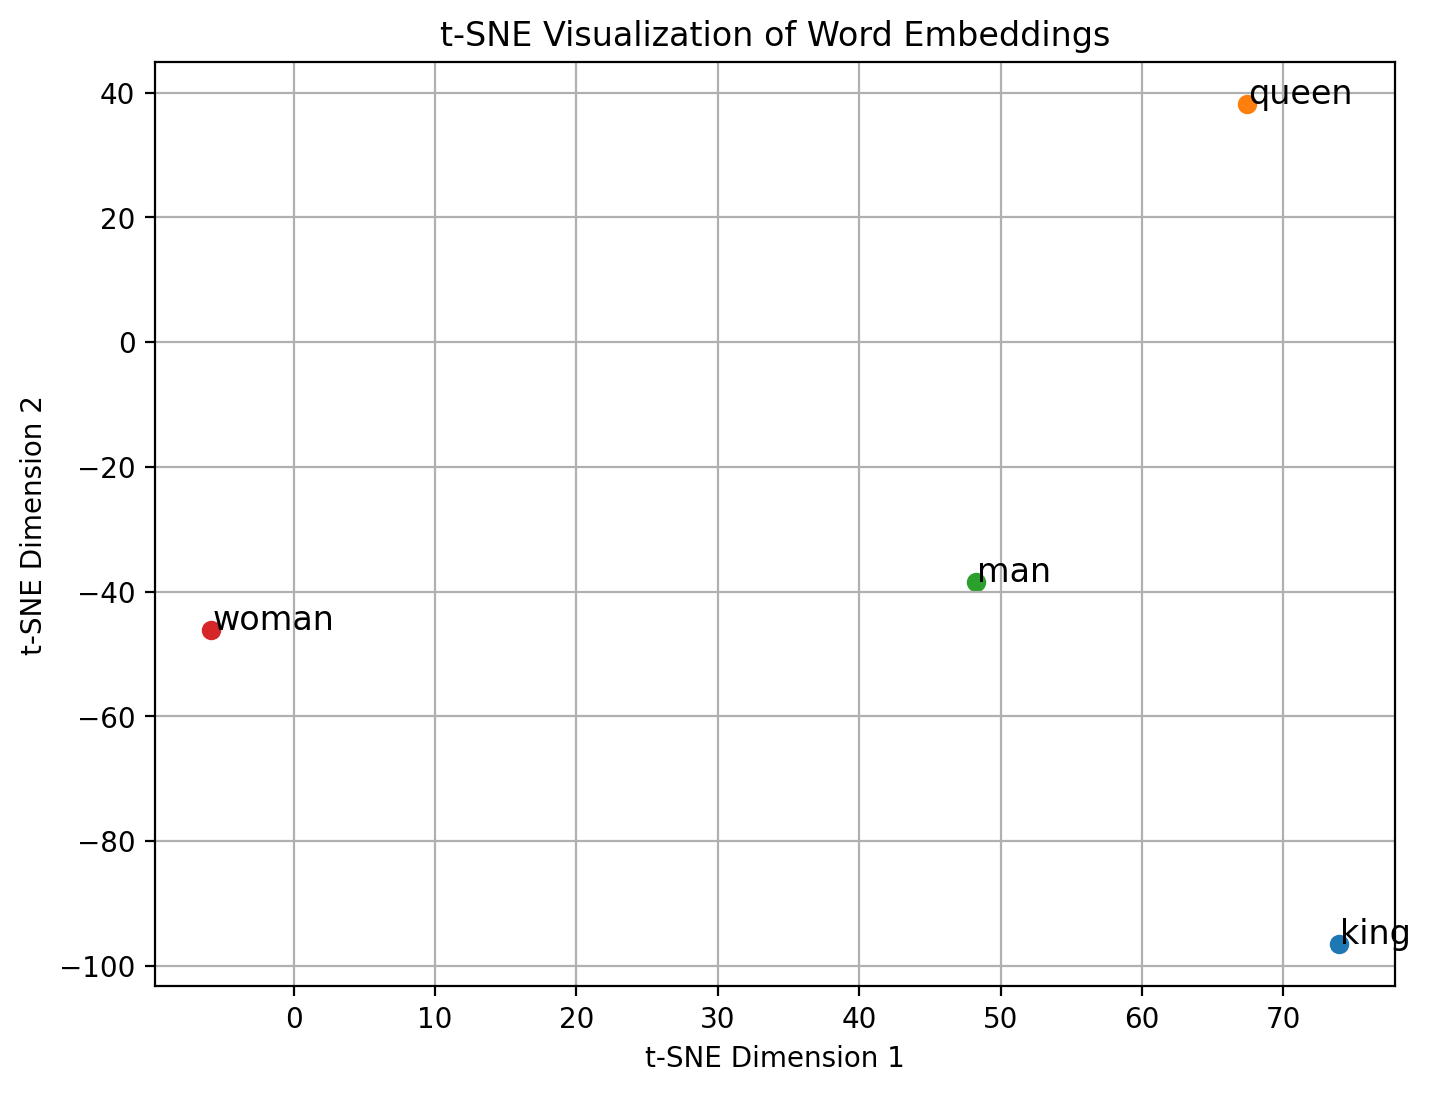

In [96]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming the model class is defined as in your earlier code
class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.lin1(x))
        x = self.lin2(x)
        return x

# Load the model
block_size = 15  # Same as used during model creation
vocab_size = len(Vocabulary)  # Vocabulary size from your data
emb_dim = 128  # Should match the embedding dimension used
hidden_size = 1024  # Should match the hidden layer size used

loaded_model = NextWord(block_size, vocab_size, emb_dim, hidden_size)
loaded_model.load_state_dict(torch.load('model_128_15_relu.pth', map_location='cpu'))  # Change the path if necessary

# Get the embedding layer
emb = loaded_model.emb

# Sample words to visualize
sample_words = ['king','queen','man','woman']

# Extract embeddings for these words
sample_embeddings = torch.stack([emb(torch.tensor(Vocabulary[word])).detach() for word in sample_words]).numpy()

# Apply t-SNE to reduce embeddings to 2D with a lower perplexity
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
embeddings_2d = tsne.fit_transform(sample_embeddings)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))

# Plot each word as a point in 2D space
for i, word in enumerate(sample_words):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.text(embeddings_2d[i, 0] + 0.1, embeddings_2d[i, 1] + 0.1, word, fontsize=12)

plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()


C:\Users\Shiva\AppData\Local\Temp\ipykernel_20280\584868722.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('model_64_5_relu.pth

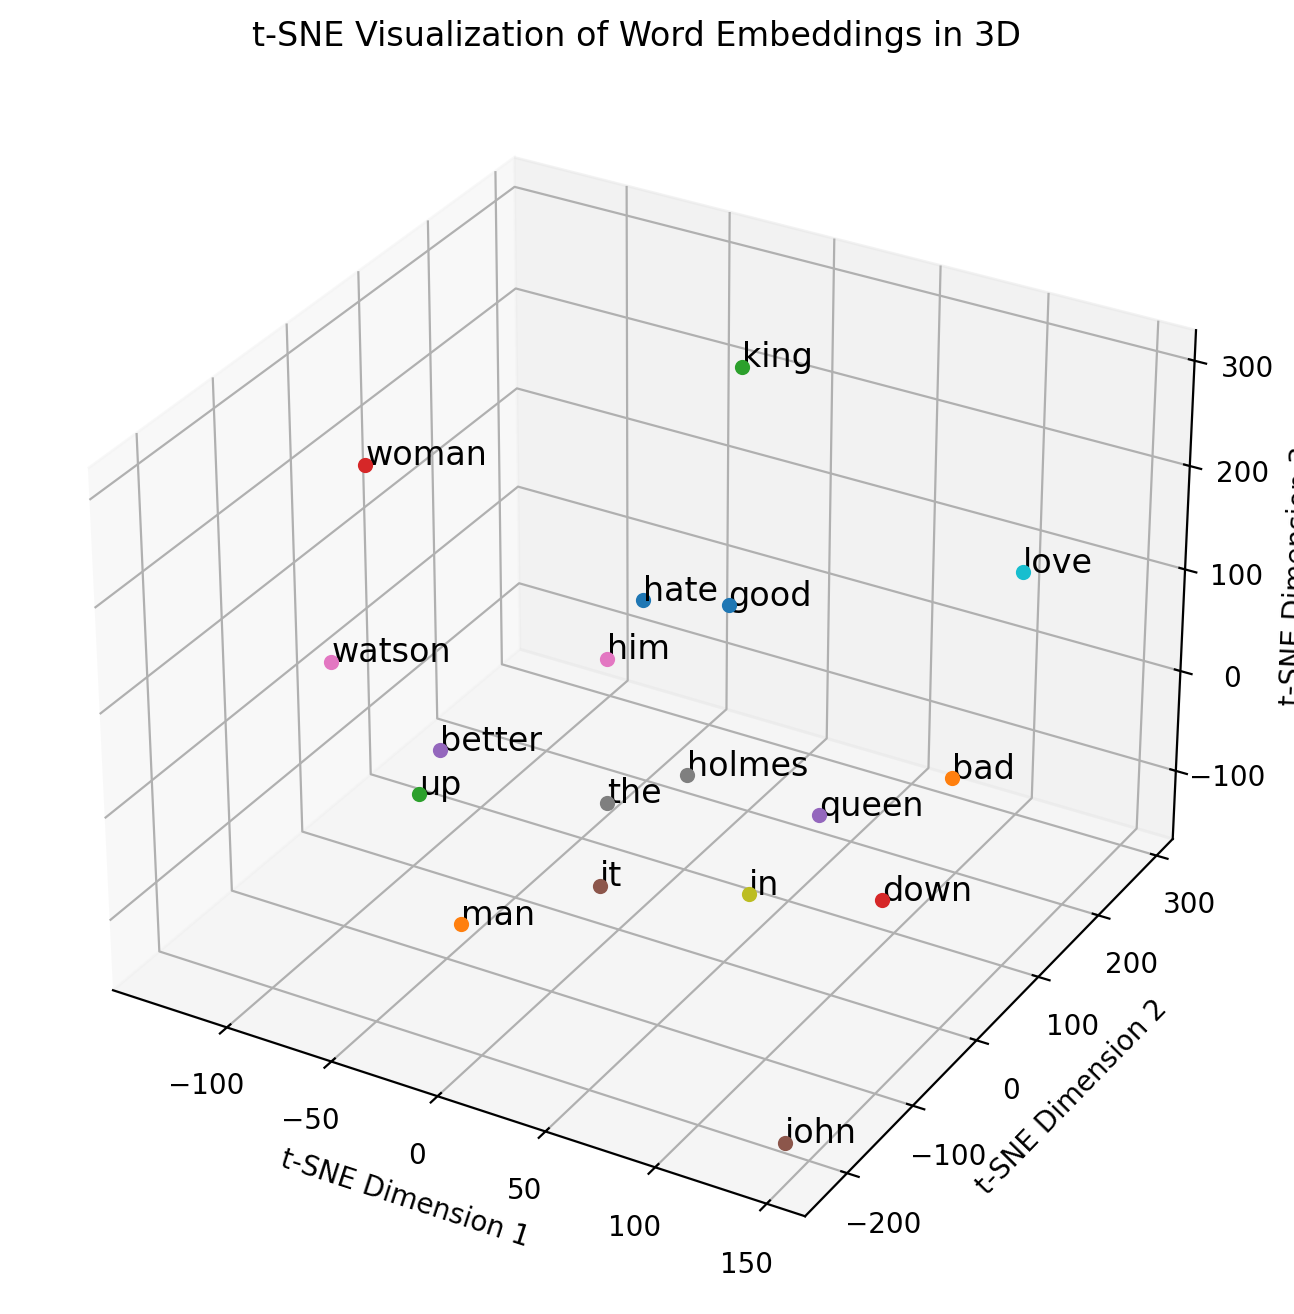

In [89]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Assuming the model class is defined as in your earlier code
class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.lin1(x))
        x = self.lin2(x)
        return x

# Load the model
block_size = 5  # Same as used during model creation
vocab_size = len(Vocabulary)  # Vocabulary size from your data
emb_dim = 64  # Should match the embedding dimension used
hidden_size = 1024  # Should match the hidden layer size used

loaded_model = NextWord(block_size, vocab_size, emb_dim, hidden_size)
loaded_model.load_state_dict(torch.load('model_64_5_relu.pth', map_location='cpu'))  # Change the path if necessary

# Get the embedding layer
emb = loaded_model.emb

# Sample words to visualize
sample_words = ['good', 'bad', 'up', 'down', 'better', 'it', 'him', 'the', 'in', 'love', 'hate', 'man', 'king', 'woman', 'queen','john','watson','holmes']

# Extract embeddings for these words
sample_embeddings = torch.stack([emb(torch.tensor(Vocabulary[word])).detach() for word in sample_words]).numpy()

# Apply t-SNE to reduce embeddings to 3D
tsne = TSNE(n_components=3, perplexity=2, random_state=42)
embeddings_3d = tsne.fit_transform(sample_embeddings)

# Plot the t-SNE results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each word as a point in 3D space
for i, word in enumerate(sample_words):
    ax.scatter(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2])
    ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], word, fontsize=12)

ax.set_title("t-SNE Visualization of Word Embeddings in 3D")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")
plt.show()


C:\Users\Shiva\AppData\Local\Temp\ipykernel_20280\666202445.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('model_128_15_relu.p

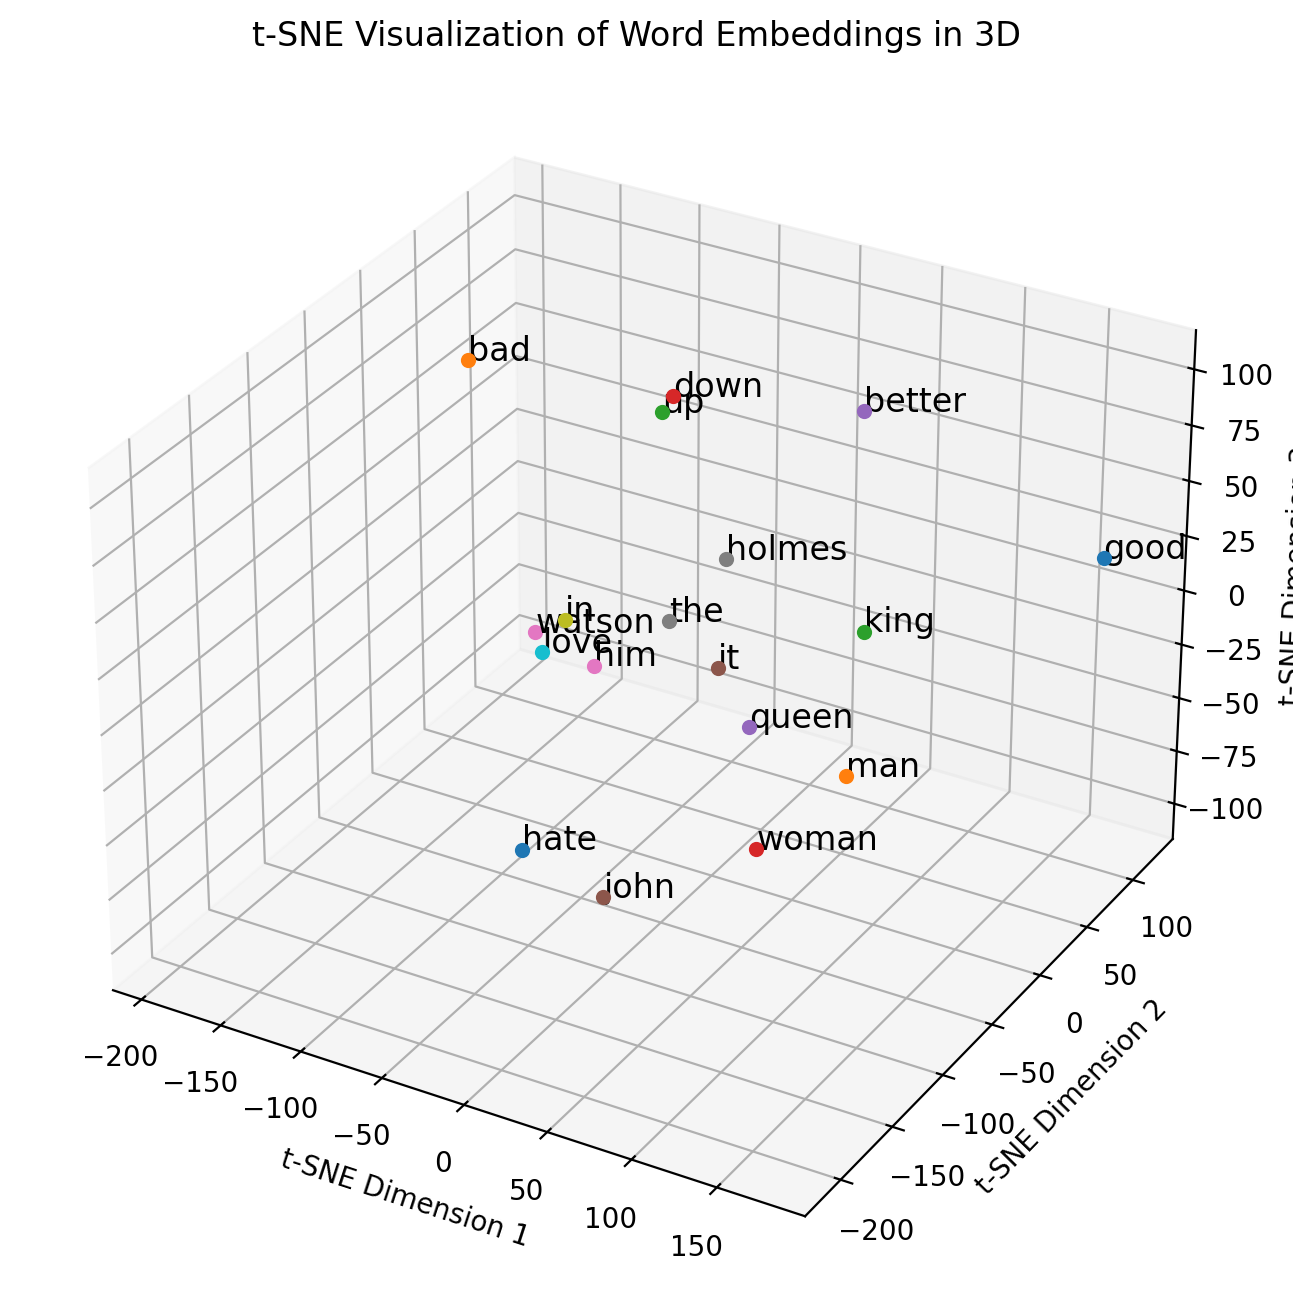

In [91]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Assuming the model class is defined as in your earlier code
class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.lin1(x))
        x = self.lin2(x)
        return x

# Load the model
block_size = 15  # Same as used during model creation
vocab_size = len(Vocabulary)  # Vocabulary size from your data
emb_dim = 128  # Should match the embedding dimension used
hidden_size = 1024  # Should match the hidden layer size used

loaded_model = NextWord(block_size, vocab_size, emb_dim, hidden_size)
loaded_model.load_state_dict(torch.load('model_128_15_relu.pth', map_location='cpu'))  # Change the path if necessary

# Get the embedding layer
emb = loaded_model.emb

# Sample words to visualize
sample_words = ['good', 'bad', 'up', 'down', 'nice', 'it', 'him', 'she','the', 'in', 'love', 'hate', 'man', 'king', 'woman', 'queen','john','watson','holmes']

# Extract embeddings for these words
sample_embeddings = torch.stack([emb(torch.tensor(Vocabulary[word])).detach() for word in sample_words]).numpy()

# Apply t-SNE to reduce embeddings to 3D
tsne = TSNE(n_components=3, perplexity=2, random_state=42)
embeddings_3d = tsne.fit_transform(sample_embeddings)

# Plot the t-SNE results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each word as a point in 3D space
for i, word in enumerate(sample_words):
    ax.scatter(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2])
    ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], word, fontsize=12)

ax.set_title("t-SNE Visualization of Word Embeddings in 3D")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")
plt.show()


In [73]:
# def models(block_size,vocab_size,emb_dim,hidden_size):
#     model = NextWord(block_size,vocab_size,emb_dim,hidden_size).to(device)
#     return model

# # model = torch.compile(model)



In [58]:
# block_size = 5
# vocab_size = len(Vocabulary)
# emb_dim = 64
# hidden_size = 1024

In [59]:
# allmodels = {}
# for emdDim in [64,128]:
#   for context_len in [4,8,10,45]:
#     m = models(context_len,len(Vocabulary),emdDim,1024,para)
#     allmodels[str(context_len)+"_"+str(emdDim)] = m



# model = models(block_size,len(Vocabulary),emb_dim,hidden_size)

In [60]:
# import time
# # for model_key, model_z in allmodels.items():
# # block_size, emb_dim = map(int, model_key.split('_'))
# X,Y = generate_X_Y(para,block_size)
# loss_fn = nn.CrossEntropyLoss()
# opt = torch.optim.AdamW(model.parameters(), lr=0.01)
# # Mini-batch training
# batch_size = 4096
# print_every = 100
# elapsed_time = []
# # print(block_size," ",emb_dim)
# epochs = 500
# for epoch in range(epochs):
#     start_time = time.time()
#     for i in range(0, X.shape[0], batch_size):
#         x = X[i:i+batch_size]
#         y = Y[i:i+batch_size]
#         y_pred = model(x)
#         loss = loss_fn(y_pred, y)
#         loss.backward()
#         opt.step()
#         opt.zero_grad()
#     end_time = time.time()
#     elapsed_time.append(end_time - start_time)
#     if epoch % print_every == 0:
#         print(epoch, loss.item())


In [61]:
# # # Path to save the model in your Drive
# model_path = f'model_{emb_dim}_{block_size}_relu.pth'

# # # Save the state dictionary
# # torch.save(model.state_dict(), model_path)

# # print(f"Model saved to {model_path}")


In [62]:
# loaded_model = NextWord(block_size, vocab_size, emb_dim, hidden_size).to(device)

# # Load the state dictionary from the file in Google Drive
# # model_path = '/content/drive/MyDrive/next_word_model.pth'
# loaded_model.load_state_dict(torch.load(model_path, map_location=device))


In [63]:
# print(generate_para(model,Vocabulary,block_size))

In [64]:
# print(generate_para(loaded_model,Vocabulary,block_size))

In [65]:
# import nltk
# from nltk.corpus import wordnet as wn
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# import torch

# # Download WordNet data if not already downloaded
# nltk.download('wordnet')

# # Initialize lists for synonym and antonym pairs
# synonym_pairs = []
# antonym_pairs = []

# # Assuming Vocabulary and emb are defined, Vocabulary being a dictionary {word: index} and emb the embedding layer
# # Iterate through each word in your vocabulary and find synonyms and antonyms
# for word in Vocabulary.keys():
#     synsets = wn.synsets(word)
    
#     # Find synonym pairs
#     for synset in synsets:
#         for lemma in synset.lemmas():
#             synonym = lemma.name().lower()
#             if synonym != word and synonym in Vocabulary:  # Ensure synonym exists in your vocabulary
#                 synonym_pairs.append((word, synonym))
#                 if len(synonym_pairs) >= 5:
#                     break
#         if len(synonym_pairs) >= 5:
#             break

#     # Find antonym pairs
#     for synset in synsets:
#         for lemma in synset.lemmas():
#             if lemma.antonyms():  # Check if antonyms exist
#                 antonym = lemma.antonyms()[0].name().lower()
#                 if antonym != word and antonym in Vocabulary:  # Ensure antonym exists in your vocabulary
#                     antonym_pairs.append((word, antonym))
#                     if len(antonym_pairs) >= 5:
#                         break
#         if len(antonym_pairs) >= 5:
#             break

#     # Stop if both lists have reached 50 pairs
#     if len(synonym_pairs) >= 5 and len(antonym_pairs) >= 5:
#         break

# # Gather all unique words from synonym and antonym pairs
# words_to_visualize = set(word for pair in (synonym_pairs + antonym_pairs) for word in pair)

# # Extract the embeddings for these words using your model's embedding layer
# # Ensure emb is the trained embedding layer
# selected_embeddings = torch.stack([emb(torch.tensor(Vocabulary[word])).detach() for word in words_to_visualize]).numpy()

# # Apply t-SNE to reduce embeddings to 2D
# tsne = TSNE(n_components=2, random_state=42)
# embeddings_2d = tsne.fit_transform(selected_embeddings)

# # Mapping words to their 2D embeddings for plotting
# word_to_position = {word: embeddings_2d[i] for i, word in enumerate(words_to_visualize)}

# # Plotting the t-SNE results
# plt.figure(figsize=(12, 10))

# # Plot synonyms in blue
# print(len(synonym_pairs))
# for word1, word2 in synonym_pairs:
#     pos1, pos2 = word_to_position[word1], word_to_position[word2]
#     plt.scatter(pos1[0], pos1[1], color='blue')
#     plt.text(pos1[0] + 0.1, pos1[1] + 0.1, word1, color='blue')
#     plt.scatter(pos2[0], pos2[1], color='blue')
#     plt.text(pos2[0] + 0.1, pos2[1] + 0.1, word2, color='blue')
#     plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 'b--')

# # # Plot antonyms in red
# # for word1, word2 in antonym_pairs:
# #     pos1, pos2 = word_to_position[word1], word_to_position[word2]
# #     plt.scatter(pos1[0], pos1[1], color='red')
# #     plt.text(pos1[0] + 0.1, pos1[1] + 0.1, word1, color='red')
# #     plt.scatter(pos2[0], pos2[1], color='red')
# #     plt.text(pos2[0] + 0.1, pos2[1] + 0.1, word2, color='red')
# #     plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 'r--')

# plt.title("t-SNE Visualization of Word Embeddings for synonyms")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.grid(True)
# plt.show()


In [66]:
Vocabulary['king']

4651

In [67]:
Vocabulary['queen']

6487

In [68]:
Vocabulary['man']

5101

In [69]:
Vocabulary['woman']

9215

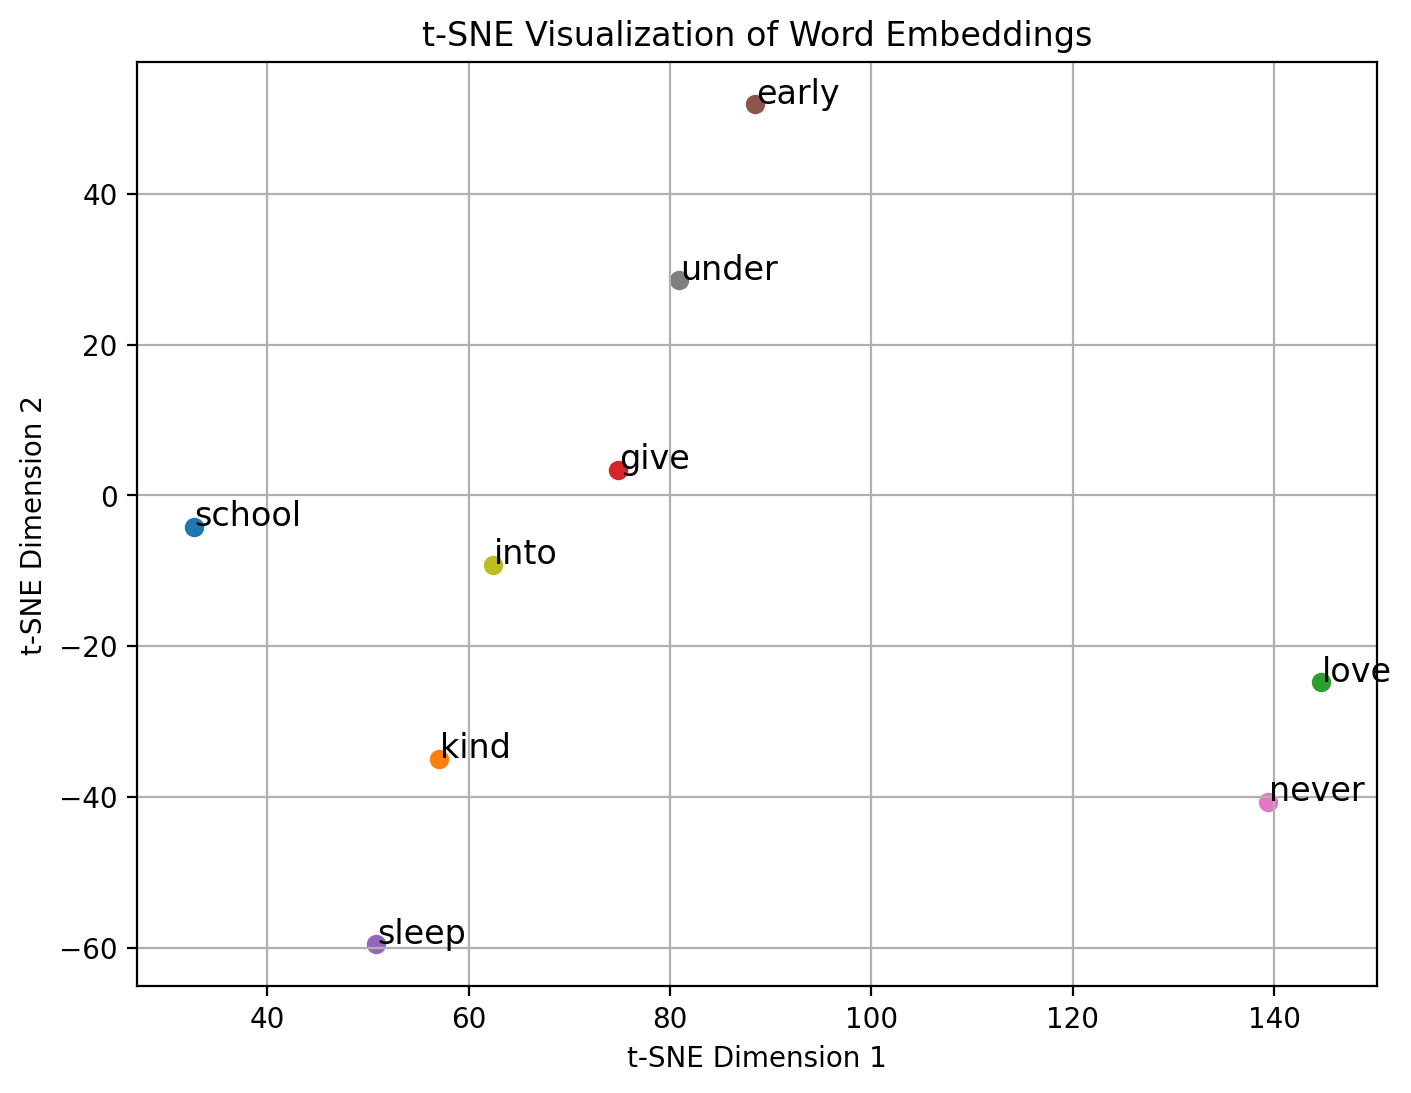

In [70]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# Sample words to visualize
sample_words = ['school', 'kind', 'love', 'give', 'sleep', 'early', 'never', 'under', 'into']

# Extract embeddings for these words
# Assuming `Vocabulary` maps words to their indices and `emb` is the embedding layer
sample_embeddings = torch.stack([emb(torch.tensor(Vocabulary[word])).detach() for word in sample_words]).numpy()

# Apply t-SNE to reduce embeddings to 2D with a lower perplexity
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
embeddings_2d = tsne.fit_transform(sample_embeddings)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))

# Plot each word as a point in 2D space
for i, word in enumerate(sample_words):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.text(embeddings_2d[i, 0] + 0.1, embeddings_2d[i, 1] + 0.1, word, fontsize=12)

plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()
